# Trying first graph model

## Dataset

In [1]:
from dataset import TMDBDataset

In [2]:
df = TMDBDataset(
    root = "./tmp",
    node_feature_method = "counter",
    node_feature_params = {'min_df': 0.1},
    node_feature_column_source = "overview",
    edge_weight_column_source = "cast",
    jaccard_distance_threshold = 0,
    graph_type = "homogenous"
)

## First model

In [3]:
import torch_geometric
import torch
import numpy as np

In [4]:
graph = df[0]

In [5]:
graph.y = np.log(graph.y)

In [6]:
split = torch_geometric.transforms.RandomNodeSplit(num_val=0, num_test=0.2)
graph = split(graph)

In [7]:
graph

Data(x=[2926, 44], edge_index=[2, 275402], edge_attr=[275402, 1], y=[2926, 1], train_mask=[2926], val_mask=[2926], test_mask=[2926])

In [8]:
graph.validate()

True

Function for plotting the MSE for each epoch

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
def plot_epochs(train, test, epoch_range=None):
    if epoch_range is None:
        epoch_range = (1, len(train) + 1)
    x = np.arange(epoch_range[0], epoch_range[1])
    n_lower = epoch_range[0] - 1
    n_upper = epoch_range[1] - 1
    plt.plot(x, train[n_lower:n_upper], label='train')
    plt.plot(x, test[n_lower:n_upper], label='text')
    plt.legend()

**Model**

In [11]:
class SimpleGCN(torch.nn.Module):
    def __init__(self, hidden_size=(16,)):
        super().__init__()
        self.conv_layers = []
        n = len(hidden_size)
        for i in range(n + 1):
            n_input = df.num_node_features if i == 0 else hidden_size[i-1]
            n_output = 1 if i == n else hidden_size[i]
            self.conv_layers.append(
                torch_geometric.nn.GCNConv(n_input, n_output)
            )
        self.conv_layers = torch.nn.ParameterList(self.conv_layers)

    def forward(self, data):
        x, edge_index, edge_weight = data.x.float(), data.edge_index.long(), data.edge_attr
        for layer in self.conv_layers:
            x = layer(x, edge_index, edge_weight)
            x = torch.nn.functional.relu(x).float()
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [64]:
hidden = (32, 32, 32, 32)
lr = 0.01
epochs = 300

In [65]:
model = SimpleGCN(hidden).to(device)
graph = graph.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

train_mse = []
test_mse = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(graph)
    loss = loss_fn(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()

    train_mse.append(loss.item())
    test_mse_val = loss_fn(out[graph.test_mask], graph.y[graph.test_mask]).item()
    test_mse.append(test_mse_val)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}, train mse: {loss.item()}, test mse: {test_mse_val}')

Epoch: 10, train mse: 38.37513732910156, test mse: 29.601917266845703
Epoch: 20, train mse: 13.337250709533691, test mse: 10.703934669494629
Epoch: 30, train mse: 17.725801467895508, test mse: 16.66522216796875
Epoch: 40, train mse: 13.922607421875, test mse: 10.35110092163086
Epoch: 50, train mse: 11.577103614807129, test mse: 9.043210983276367
Epoch: 60, train mse: 10.690706253051758, test mse: 8.943085670471191
Epoch: 70, train mse: 9.752365112304688, test mse: 8.15007209777832
Epoch: 80, train mse: 8.426335334777832, test mse: 7.806344509124756
Epoch: 90, train mse: 7.592257976531982, test mse: 7.243714809417725
Epoch: 100, train mse: 7.012513637542725, test mse: 6.938525199890137
Epoch: 110, train mse: 6.5572829246521, test mse: 6.701485633850098
Epoch: 120, train mse: 6.227438449859619, test mse: 6.522300720214844
Epoch: 130, train mse: 6.004086017608643, test mse: 6.445830821990967
Epoch: 140, train mse: 5.937836647033691, test mse: 6.424664497375488
Epoch: 150, train mse: 5.816

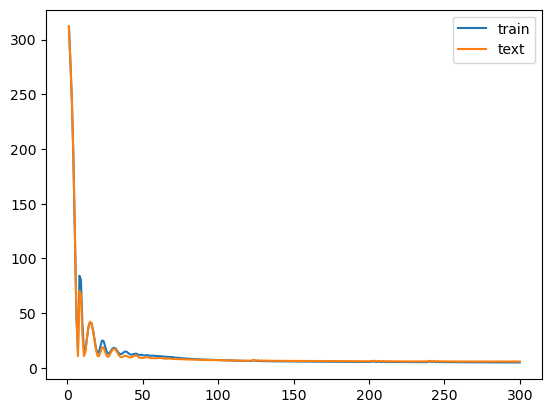

In [66]:
plot_epochs(train_mse, test_mse)
plt.show()

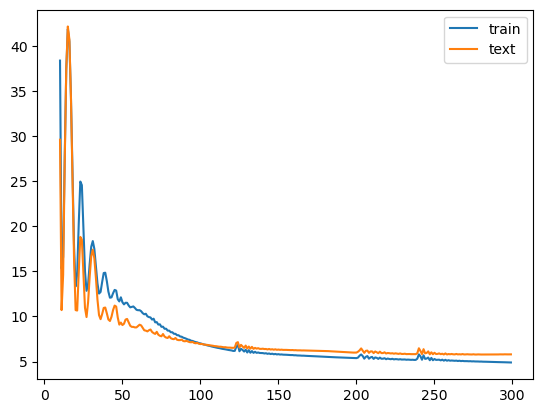

In [67]:
plot_epochs(train_mse, test_mse, (10, 300))
plt.show()